In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.flatten import Flatten

import matplotlib.pyplot as plt
from datetime import datetime

# Hyperparameters

In [2]:
batchsize = 100
num_class = 10
lr = 0.001
num_epochs = 50

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Create and read Dataset MNIST**


In [4]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batchsize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batchsize,
                                          shuffle=True)

# Create Model

In [5]:
def cnn():
  network = nn.Sequential(
                          nn.Conv2d(1, 16, 3, stride=1, padding=1),
                          nn.ReLU(),

                          nn.Conv2d(16, 32, 3, stride=1, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=3, padding=1, stride=2),

                          Flatten(),

                          nn.Linear(32 * 14 * 14, num_class))
  return network

# Decorator

In [ ]:
def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = datetime.now()
        result = func(*args, **kwargs)
        end_time = datetime.now()
        duration = end_time - start_time
        
        hour = duration.seconds//3600
        minute = duration.seconds//60
        secend = duration.seconds%60
        print(f'Total Time: {hour} : {minute} : {secend}')
        
        return result
    
    return wrapper



# Train Model

## Adam Optimizer

In [7]:
model_adam = cnn().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr)

total_loss = []

@log_time
def train_Adam(epoch):
    start_time = datetime.now()
    for i in range(epoch):
        model_adam.train()
        for j, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model_adam(imgs)
            loss_value = loss_function(out, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            if (j+1) % 10 == 0:
                total_loss.append(loss_value)
                print(f'Train, Epoch [{i+1}/{epoch}] Loss: {loss_value.item():.2f}')

            if j == 10:
                break



In [ ]:
train_Adam(num_epochs)

## RMSprop Optimizer

In [9]:
model_rmsprop = cnn().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model_rmsprop.parameters(), lr=lr)

total_loss_rms = []

@log_time
def train_RMSprop(epoch):
  start_time = datetime.now()
  for i in range(epoch):
    model_rmsprop.train()
    for j, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model_rmsprop(imgs)
        loss_value = loss_function(out, labels)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        if (j+1) % 10 == 0:
            total_loss_rms.append(loss_value)
            print(f'Train, Epoch [{i+1}/{epoch}] Loss: {loss_value.item():.2f}')

        if j == 10:
            break

In [10]:
train_RMSprop(num_epochs)

Train, Epoch [1/50] Loss: 1.90
Train, Epoch [2/50] Loss: 0.97
Train, Epoch [3/50] Loss: 0.89
Train, Epoch [4/50] Loss: 0.41
Train, Epoch [5/50] Loss: 0.35
Train, Epoch [6/50] Loss: 0.43
Train, Epoch [7/50] Loss: 0.31
Train, Epoch [8/50] Loss: 0.27
Train, Epoch [9/50] Loss: 0.42
Train, Epoch [10/50] Loss: 0.24
Train, Epoch [11/50] Loss: 0.22
Train, Epoch [12/50] Loss: 0.30
Train, Epoch [13/50] Loss: 0.32
Train, Epoch [14/50] Loss: 0.18
Train, Epoch [15/50] Loss: 0.20
Train, Epoch [16/50] Loss: 0.10
Train, Epoch [17/50] Loss: 0.15
Train, Epoch [18/50] Loss: 0.08
Train, Epoch [19/50] Loss: 0.13
Train, Epoch [20/50] Loss: 0.08
Train, Epoch [21/50] Loss: 0.19
Train, Epoch [22/50] Loss: 0.12
Train, Epoch [23/50] Loss: 0.28
Train, Epoch [24/50] Loss: 0.19
Train, Epoch [25/50] Loss: 0.15
Train, Epoch [26/50] Loss: 0.15
Train, Epoch [27/50] Loss: 0.12
Train, Epoch [28/50] Loss: 0.11
Train, Epoch [29/50] Loss: 0.16
Train, Epoch [30/50] Loss: 0.07
Train, Epoch [31/50] Loss: 0.05
Train, Epoch [32/

## Newton Optimizer

In [11]:
!pip install backpack-for-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from backpack import backpack, extend
from backpack.extensions import DiagGGNMC

In [13]:
class NewtonOptimizer(torch.optim.Optimizer):
    def __init__(self, parameters, step_size, damping):
        super().__init__(parameters, dict(step_size=step_size, damping=damping))

    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                step_direction = p.grad / (p.diag_ggn_mc + group["damping"])
                p.data.add_(step_direction, alpha=-group["step_size"])

In [17]:
model_newton = cnn().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = NewtonOptimizer(model_newton.parameters(), step_size=0.05, damping=1.)

extend(model_newton)
extend(loss_function)

total_loss_newt = []

@log_time
def train_newton(epoch):
  start_time = datetime.now()
  for i in range(epoch):
    model_newton.train()
    for j, (imgs, labels) in enumerate(train_loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      out = model_newton(imgs)
      loss_value = loss_function(out, labels)
      model_newton.zero_grad()
      
      with backpack(DiagGGNMC()):
        loss_value.backward()
      optimizer.step()
      if (j+1) % 10 == 0:
        total_loss_newt.append(loss_value)
        print(f'Train, Epoch [{i+1}/{epoch}] Loss: {loss_value.item():.2f}')

      if j == 10:
        break


In [18]:
train_newton(num_epochs)

Train, Epoch [1/50] Loss: 2.13
Train, Epoch [2/50] Loss: 1.40
Train, Epoch [3/50] Loss: 1.01
Train, Epoch [4/50] Loss: 0.68
Train, Epoch [5/50] Loss: 1.04
Train, Epoch [6/50] Loss: 0.58
Train, Epoch [7/50] Loss: 1.29
Train, Epoch [8/50] Loss: 0.52
Train, Epoch [9/50] Loss: 0.55
Train, Epoch [10/50] Loss: 0.37
Train, Epoch [11/50] Loss: 0.33
Train, Epoch [12/50] Loss: 0.46
Train, Epoch [13/50] Loss: 0.32
Train, Epoch [14/50] Loss: 0.45
Train, Epoch [15/50] Loss: 0.48
Train, Epoch [16/50] Loss: 0.30
Train, Epoch [17/50] Loss: 0.22
Train, Epoch [18/50] Loss: 0.46
Train, Epoch [19/50] Loss: 0.34
Train, Epoch [20/50] Loss: 0.50
Train, Epoch [21/50] Loss: 0.40
Train, Epoch [22/50] Loss: 0.33
Train, Epoch [23/50] Loss: 0.32
Train, Epoch [24/50] Loss: 0.31
Train, Epoch [25/50] Loss: 0.40
Train, Epoch [26/50] Loss: 0.25
Train, Epoch [27/50] Loss: 0.32
Train, Epoch [28/50] Loss: 0.32
Train, Epoch [29/50] Loss: 0.25
Train, Epoch [30/50] Loss: 0.23
Train, Epoch [31/50] Loss: 0.31
Train, Epoch [32/

# Test Model

In [19]:
model_adam.eval()
corrects1 = 0
num_steps = len(test_loader)

for j, (imgs, labels) in enumerate(test_loader):
  imgs = imgs.to(device)
  labels = labels.to(device)
  out = model_adam(imgs)
  predicted1 = torch.argmax(out, 1)
  corrects1 += torch.sum(predicted1 == labels)
  if (j+1) % 100 == 0:
    accuracy1 = 100*corrects1/((j+1)*batchsize)
    print(f'Step [{j+1}/{num_steps}] Acc {accuracy1:.4f}')

Step [100/600] Acc 97.4400
Step [200/600] Acc 97.4200
Step [300/600] Acc 97.4800
Step [400/600] Acc 97.5975
Step [500/600] Acc 97.6060
Step [600/600] Acc 97.6100


# Plots

In [20]:
loss_adam = []
for i in total_loss:
    loss_adam.append(i.item())

loss_rms = []
for i in total_loss_rms:
    loss_rms.append(i.item())


loss_newton = []
for i in total_loss_newt:
    loss_newton.append(i.item())

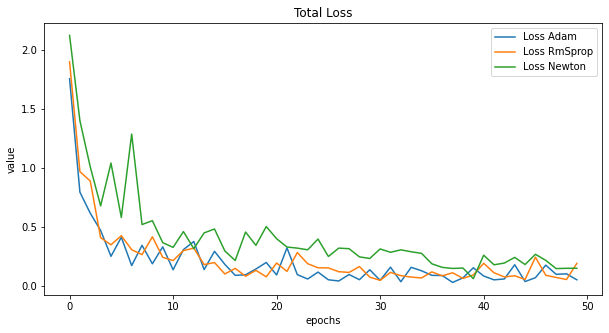

In [25]:
plt.figure(figsize=(10,5))
plt.title("Total Loss")
plt.plot(loss_adam, label="Loss Adam")
plt.plot(loss_rms, label="Loss RmSprop")
plt.plot(loss_newton, label="Loss Newton")
plt.xlabel("epochs")
plt.ylabel("value")
plt.legend()
plt.show()